<a href="https://colab.research.google.com/github/so5/YOLO-seminar/blob/main/YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このnotebookは [公式webサイト](https://pjreddie.com/darknet/yolo/) の "Detection Using A Pre-Trained Model" セクションに書かれている内容を順にgoogle colab上で実行するものです。


---



#事前準備

これ以降の手順を実行するには、次のツール、ライブラリが必要になります。
- git
- GNU make
- Cコンパイラ(gcc等)
- OpenCV
- wget

google colabの場合、`wget`以外はインストール済なので`wget`のみをインストールします。

In [1]:
!apt update && apt install wget

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

# darknetのビルド
darknetはC言語で書かれたプログラムなので、pythonなどのプログラムとは違い
ソースコードから実行ファイルをビルドする必要があります。

In [2]:
!git clone https://github.com/pjreddie/darknet 

Cloning into 'darknet'...
remote: Enumerating objects: 5946, done.
remote: Total 5946 (delta 0), reused 0 (delta 0), pack-reused 5946
Receiving objects: 100% (5946/5946), 6.37 MiB | 22.10 MiB/s, done.
Resolving deltas: 100% (3928/3928), done.


In [3]:
%cd darknet

/content/darknet


In [5]:
!make OPENCV=1 all

nvcc  -gencode arch=compute_30,code=sm_30 -gencode arch=compute_35,code=sm_35 -gencode arch=compute_50,code=[sm_50,compute_50] -gencode arch=compute_52,code=[sm_52,compute_52] -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ --compiler-options "-Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU" -c ./src/convolutional_kernels.cu -o obj/convolutional_kernels.o
nvcc fatal   : Unsupported gpu architecture 'compute_30'
Makefile:92: recipe for target 'obj/convolutional_kernels.o' failed
make: *** [obj/convolutional_kernels.o] Error 1


#成果物の確認

正常にビルドが終了していれば、`darknet` という実行ファイルが生成されています。
また、`cfg` ディレクトリの中には複数の機械学習モデルの設定ファイルが入っているので確認してみましょう。


In [27]:
ls -l darknet

-rwxr-xr-x 1 root root 786200 May 26 08:16 darknet*


In [28]:
ls cfg

alexnet.cfg          imagenet1k.data               vgg-16.cfg
cifar.cfg            imagenet22k.dataset           vgg-conv.cfg
cifar.test.cfg       imagenet9k.hierarchy.dataset  voc.data
coco.data            jnet-conv.cfg                 writing.cfg
combine9k.data       openimages.data               yolo9000.cfg
darknet19_448.cfg    resnet101.cfg                 yolov1.cfg
darknet19.cfg        resnet152.cfg                 yolov1-tiny.cfg
darknet53_448.cfg    resnet18.cfg                  yolov2.cfg
darknet53.cfg        resnet34.cfg                  yolov2-tiny.cfg
darknet9000.cfg      resnet50.cfg                  yolov2-tiny-voc.cfg
darknet.cfg          resnext101-32x4d.cfg          yolov2-voc.cfg
densenet201.cfg      resnext152-32x4d.cfg          yolov3.cfg
extraction22k.cfg    resnext50.cfg                 yolov3-openimages.cfg
extraction.cfg       rnn.cfg                       yolov3-spp.cfg
extraction.conv.cfg  rnn.train.cfg                 yolov3-tiny.cfg
go.cfg               str

In [14]:
cat cfg/yolov3.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

#学習済データを使って物体検出

yolov3を様々なデータで学習した成果(weightsファイル)が公開されているので、これをダウンロードしてきて、dataディレクトリ以下にある画像ファイル内の物体検知をしましょう。

学習済みデータをダウンロードします


In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-05-26 07:26:15--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  20.4MB/s    in 12s     

2022-05-26 07:26:28 (19.1 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



ダウンロードしてきた学習済データを使って、`data/dog.jpg`に映っている物体の検出を行ないます

In [9]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

結果は`predictinos.jpg`というファイルに出力されるので表示します

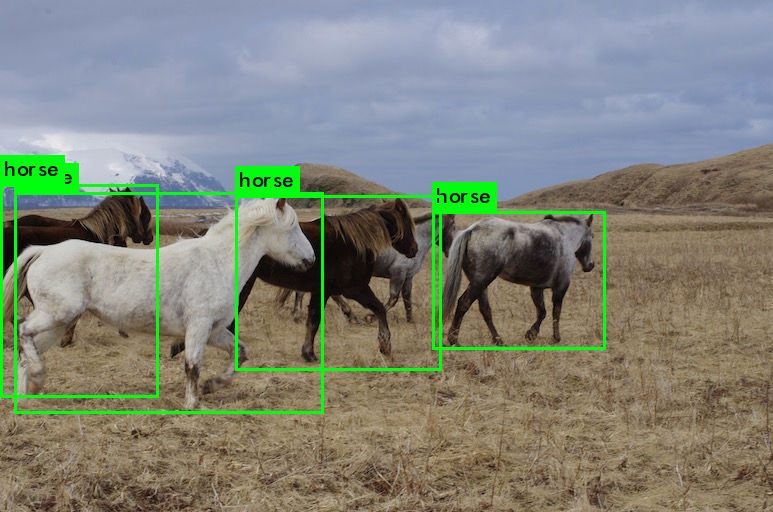

In [16]:
from IPython.display import Image
display(Image('predictions.jpg'))

# 別のファイルでも試してみる

dataディレクトリの下にdog.jpg以外にも複数の画像ファイルが用意されているので
`dog.jpg`の部分を色々と置き換えて試してみましょう!
- data/dog.jpg
-    data/giraffe.jpg
-  data/kite.jpg
-    data/scream.jpg
- data/eagle.jpg 
- data/horses.jpg
-   data/person.jpg



In [19]:
! ./darknet detect cfg/yolov3.cfg yolov3.weights  data/giraffe.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

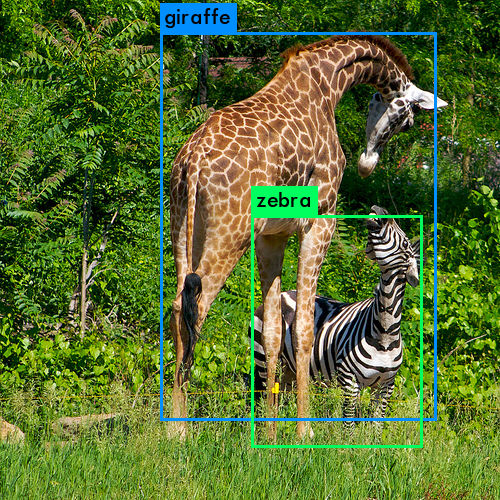

In [20]:
display(Image('predictions.jpg'))

#動画内の物体検知


In [31]:
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights test.mp4

Demo
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 1